<img src="../squeemos_blk.png" width=200 height=200 />

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns; sns.set()
import csv

from PIL import Image, ImageDraw
import os
import shutil

from mpl_toolkits.basemap import Basemap

import functools
import operator

#there is currently a bug in panda's scatter_matrix that produces a warning that has no affect on what I'm doin :)
import warnings
warnings.filterwarnings("ignore")

In [2]:
#load in the data
df = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False, delim_whitespace=True)
df.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

df_center = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_Reduced_Trackfile.txt',header=None,names=["Year","Month","Day","Hour","Lat","Long","Min_Pressure","Max_Winds","Unused"],low_memory=False,sep='\t')
df_center.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

df_time = pd.DataFrame()
df_time['cluster'] = 0

In [3]:
display(df.info())
display(df_center.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226789 entries, 0 to 226788
Data columns (total 10 columns):
Year                226789 non-null int64
Month               226789 non-null int64
Day                 226789 non-null int64
Hour                226789 non-null int64
Min                 226789 non-null int64
Sec                 226789 non-null float64
Lat                 226789 non-null float64
Long                226789 non-null float64
Dist_East_West      226789 non-null float64
Dist_North_South    226789 non-null float64
dtypes: float64(5), int64(5)
memory usage: 19.0 MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 9 columns):
Year            61 non-null int64
Month           61 non-null int64
Day             61 non-null int64
Hour            61 non-null int64
Lat             61 non-null float64
Long            61 non-null float64
Min_Pressure    61 non-null int64
Max_Winds       61 non-null int64
Unused          61 non-null int64
dtypes: float64(2), int64(7)
memory usage: 4.8 KB


None

In [4]:
#make a dataframe that contains strikes in time intervals
minutes_between = 30
cluster = 0

for x in range(len(df['Month'].unique())):
    month = df['Month'].unique()[x]
    for y in range(len(df[df['Month'] == df['Month'].unique()[x]]['Day'].unique())):
        day = df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]
        for z in range(len(df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique())):
            hour = df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique()[z]
            for w in range(0,60,minutes_between):
                minute = w
                aeon_sucks = df[(df['Month'] == month) & (df['Day'] == day) & (df['Hour'] == hour) & (df['Min'] >= minute) & (df['Min'] <= minute + minutes_between)]
                aeon_sucks['cluster'] = cluster
                df_time = df_time.append(aeon_sucks, ignore_index=True)
                cluster+=1
df_time['distance'] = np.sqrt((df_time['Dist_East_West'] * df_time['Dist_East_West']) + 
                                (df_time['Dist_North_South'] * df_time['Dist_North_South']))
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230720 entries, 0 to 230719
Data columns (total 12 columns):
Day                 230720 non-null float64
Dist_East_West      230720 non-null float64
Dist_North_South    230720 non-null float64
Hour                230720 non-null float64
Lat                 230720 non-null float64
Long                230720 non-null float64
Min                 230720 non-null float64
Month               230720 non-null float64
Sec                 230720 non-null float64
Year                230720 non-null float64
cluster             230720 non-null int64
distance            230720 non-null float64
dtypes: float64(11), int64(1)
memory usage: 21.1 MB


In [5]:
#apply date restriction if desired
df_time = df_time[(df_time['Year'] == 2017) &
                   (df_time['Month'] == 8) &
                   (df_time['Day'] == 27) &
                   (df_time['Hour'] == 23) &
                   (df_time['Min'] == 30)]
df_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 5142 to 5171
Data columns (total 12 columns):
Day                 30 non-null float64
Dist_East_West      30 non-null float64
Dist_North_South    30 non-null float64
Hour                30 non-null float64
Lat                 30 non-null float64
Long                30 non-null float64
Min                 30 non-null float64
Month               30 non-null float64
Sec                 30 non-null float64
Year                30 non-null float64
cluster             30 non-null int64
distance            30 non-null float64
dtypes: float64(11), int64(1)
memory usage: 3.0 KB


In [6]:
def find_centers(df):
    if df.shape[0] > 0:
        num_clusters = 5
        if df.shape[0] < num_clusters:
            num_clusters = df.shape[0]
        kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
        kmeans.fit(df[['Lat', 'Long']])
        df['cluster_label'] = kmeans.fit_predict(df[['Lat', 'Long']])
        centers = kmeans.cluster_centers_
        return centers
    result = np.empty((2,1))
    result[:] = np.NaN
    return result

def kmeansify_inner():
    centers = []
    df_inner_temp = df_time.copy()
    df_inner_temp = df_inner_temp[df_inner_temp['distance'] <= 100]
    end = df_inner_temp['cluster'].max()
    for current_chunk in range(1,end):
        df_inner = df_time.copy()
        df_inner = df_inner[(df_inner['distance'] <= 100) & (df_inner['cluster'] == current_chunk)]
        centers.append(find_centers(df_inner))
    
    #flatten the list
    centers = functools.reduce(operator.iconcat, centers, [])
    #drop nan
    centers = [x for x in centers if str(x) != 'nan']
    return centers

def kmeansify_rainband():
    centers = []
    df_rainband_temp = df_time.copy()
    df_rainband_temp = df_rainband_temp[(df_rainband_temp['distance'] >= 200) & (df_rainband_temp['distance'] <= 400)]
    end = df_rainband_temp['cluster'].max()
    for current_chunk in range(1,end):
        df_rainband = df_time.copy()
        df_rainband = df_rainband[(df_rainband['distance'] >= 200) & (df_rainband['distance'] <= 400)]
        centers.append(find_centers(df_rainband))
    
    #flatten the list
    centers = functools.reduce(operator.iconcat, centers, [])
    #drop nan
    centers = [x for x in centers if str(x) != 'nan']
    return centers

def kmeansify_outer():
    centers = []
    df_outer_temp = df_time.copy()
    df_outer_temp = df_outer_temp[(df_outer_temp['distance'] >= 400) & (df_outer_temp['distance'] <= 600)]
    end = df_outer_temp['cluster'].max()
    for current_chunk in range(1,end):
        df_outer = df_time.copy()
        df_outer = df_outer[(df_outer['distance'] >= 400) & (df_outer['distance'] <= 600)]
        centers.append(find_centers(df_outer))
    
    #flatten the list
    centers = functools.reduce(operator.iconcat, centers, [])
    #drop nan
    centers = [x for x in centers if str(x) != 'nan']
    return centers

In [7]:
inner_clusters = kmeansify_inner()
rainband_clusters = kmeansify_rainband()
outer_clusters = kmeansify_outer()

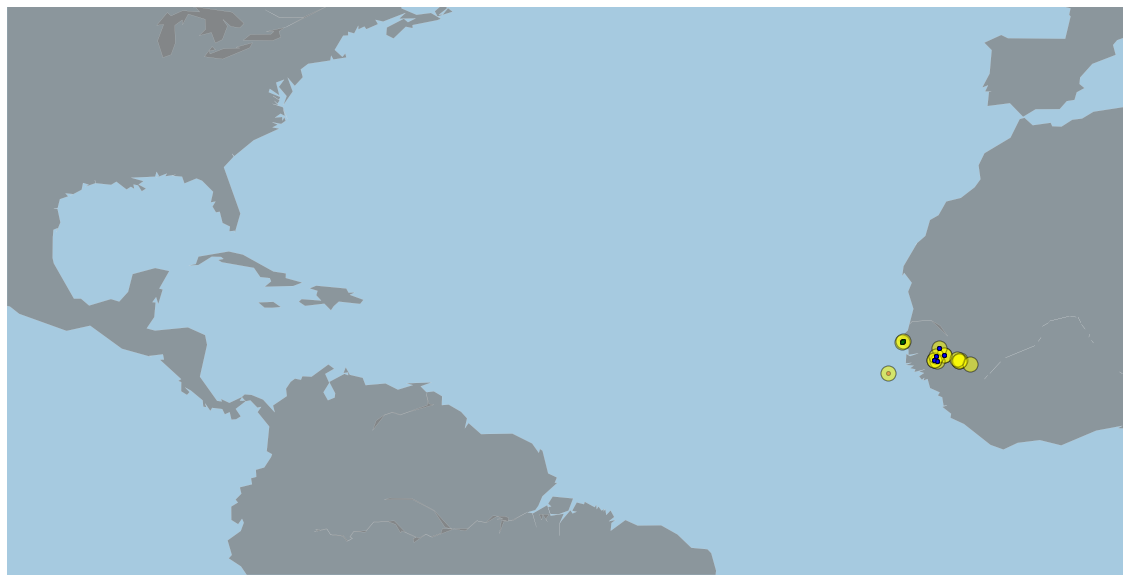

In [17]:
'''
df_inner.plot.scatter(x='Lat',y='Long', c=labels, s=50, cmap='spring', figsize=(40,40))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s= 200, alpha=.5)
plt.show()'''
inner_centers = pd.DataFrame(data=inner_clusters, columns=["Lat", "Long"])
rainband_centers = pd.DataFrame(data=rainband_clusters, columns=["Lat", "Long"])
outer_centers = pd.DataFrame(data=outer_clusters, columns=["Lat", "Long"])

ln = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False,sep=' ')
minLong_, minLat_, maxLong_, maxLat_ = ln['Long'].min(), ln['Lat'].min(), ln['Long'].max(), ln['Lat'].max()
buffer = 10

plt.figure(figsize=(20,20))
m = Basemap(llcrnrlon=minLong_-buffer, llcrnrlat=minLat_-buffer,urcrnrlon=maxLong_+buffer,urcrnrlat=maxLat_+buffer,lon_0=0,lat_0=0)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")

# Plot the lightning data
m.plot(df_time['Long'], df_time['Lat'], linestyle='none', marker="o", markersize=15, alpha=0.3, c="yellow", markeredgecolor="black", markeredgewidth=1)
m.plot(inner_centers['Long'], inner_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="red", markeredgecolor="black", markeredgewidth=1)
m.plot(rainband_centers['Long'], rainband_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="green", markeredgecolor="black", markeredgewidth=1)
m.plot(outer_centers['Long'], outer_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="blue", markeredgecolor="black", markeredgewidth=1)

plt.show()

In [9]:
#DEPRECATED
'''#elbow graph for visual estimation of ideal cluster count
clusters = range(1,16)

kmeans = [KMeans(n_clusters=i) for i in clusters]

y = df[['Lat']]
x = df[['Long']]

score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]

plt.plot(clusters, score)

plt.show()'''

'''#kmeans using the set cluster count
kmeans = KMeans(n_clusters=4, init='k-means++')
cluster_df = coord_df
kmeans.fit(cluster_df)
cluster_df['cluster'] = kmeans.fit_predict(cluster_df)
inertia = kmeans.inertia_
labels = kmeans.predict(cluster_df[cluster_df.columns[:2]])
centers = kmeans.cluster_centers_

cluster_df.plot.scatter(x='Lat',y='Long', c=labels, s=50, cmap='spring', figsize=(20,20))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s= 200, alpha=.5)

plt.show()'''

'''for n_clusters in range(1,16):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
        kmeans.fit(cluster_df)
        inertia = kmeans.inertia_
        print("Cluster count: ", n_clusters, "\tInertia: ", inertia)
        '''

'for n_clusters in range(1,16):\n        kmeans = KMeans(n_clusters=n_clusters, init=\'k-means++\')\n        kmeans.fit(cluster_df)\n        inertia = kmeans.inertia_\n        print("Cluster count: ", n_clusters, "\tInertia: ", inertia)\n        '